In [518]:
import pandas as pd
import numpy as np
import json
import geopandas
from shapely.geometry import Point
import urllib.request
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm



In [519]:
complaint = pd.read_csv('NYPD_Complaint_Data_Historic.csv')

In [520]:
complaint.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6983207 entries, 0 to 6983206
Data columns (total 35 columns):
 #   Column             Dtype  
---  ------             -----  
 0   CMPLNT_NUM         int64  
 1   CMPLNT_FR_DT       object 
 2   CMPLNT_FR_TM       object 
 3   CMPLNT_TO_DT       object 
 4   CMPLNT_TO_TM       object 
 5   ADDR_PCT_CD        float64
 6   RPT_DT             object 
 7   KY_CD              int64  
 8   OFNS_DESC          object 
 9   PD_CD              float64
 10  PD_DESC            object 
 11  CRM_ATPT_CPTD_CD   object 
 12  LAW_CAT_CD         object 
 13  BORO_NM            object 
 14  LOC_OF_OCCUR_DESC  object 
 15  PREM_TYP_DESC      object 
 16  JURIS_DESC         object 
 17  JURISDICTION_CODE  float64
 18  PARKS_NM           object 
 19  HADEVELOPT         object 
 20  HOUSING_PSA        object 
 21  X_COORD_CD         float64
 22  Y_COORD_CD         float64
 23  SUSP_AGE_GROUP     object 
 24  SUSP_RACE          object 
 25  SUSP_SEX          

In [521]:
complaint.tail()

CMPLNT_NUM CMPLNT_FR_DT CMPLNT_FR_TM CMPLNT_TO_DT CMPLNT_TO_TM  \
6983202   202934942   09/12/2014     17:50:00   09/12/2014     17:55:00   
6983203   327134526   12/20/2012     13:30:00   12/20/2012     13:35:00   
6983204   671421638   04/04/2013     13:00:00   04/04/2013     15:30:00   
6983205   980011525   09/09/2015     13:00:00   09/09/2015     13:50:00   
6983206   719347170   08/19/2012     01:00:00   08/19/2012     01:30:00   

         ADDR_PCT_CD      RPT_DT  KY_CD                     OFNS_DESC  PD_CD  \
6983202         28.0  09/12/2014    341                 PETIT LARCENY  333.0   
6983203         70.0  12/20/2012    344  ASSAULT 3 & RELATED OFFENSES  101.0   
6983204         90.0  04/04/2013    341                 PETIT LARCENY  321.0   
6983205         13.0  09/09/2015    360                           NaN  649.0   
6983206         73.0  08/19/2012    344  ASSAULT 3 & RELATED OFFENSES  101.0   

         ... SUSP_SEX TRANSIT_DISTRICT   Latitude  Longitude  \
6983202  ...      NaN              NaN  40.808374 -73.946886   
6983203  ...      NaN              NaN  40.648648 -73.967731   
6983204  ...      NaN              NaN  40.716045 -73.964163   
6983205  ...      NaN              4.0  40.735211 -73.991691   
6983206  ...        M              NaN  40.667573 -73.907296   

                               Lat_Lon              PATROL_BORO  \
6983202  (40.808374136, -73.946885823)    PATROL BORO MAN NORTH   
6983203  (40.648648047, -73.967730515)  PATROL BORO BKLYN SOUTH   
6983204  (40.716044892, -73.964162712)  PATROL BORO BKLYN NORTH   
6983205  (40.735211323, -73.991691398)    PATROL BORO MAN SOUTH   
6983206  (40.667573424, -73.907295766)  PATROL BORO BKLYN NORTH   

              STATION_NAME  VIC_AGE_GROUP VIC_RACE VIC_SEX  
6983202                NaN            NaN  UNKNOWN       D  
6983203                NaN          25-44    BLACK       F  
6983204                NaN          45-64    WHITE       M  
6983205  DISTRICT 4 OFFICE            NaN  UNKNOWN       E  
6983206                NaN          25-44    BLACK       F  

[5 rows x 35 columns]

When a complaint contains only a From Datetime, this represents the exact datetime when the crime incident was reported to occur. In the event a complaint has both a From Datetime and a To Datetime, a time range (rather than an exact time) was specified for the occurrence of the crime. In rare cases, records containing only a To Datetime indicate only a known endpoint to the crime. Thus, we use "from date" as the date to analysis.

In [522]:
complaint["date"] = pd.to_datetime(complaint["CMPLNT_FR_DT"], format='%m/%d/%Y', errors='coerce')

In [523]:
complaint["date"].max()

Timestamp('2019-12-31 00:00:00')

In [524]:
complaint2019 = complaint[(complaint["date"]>=pd.to_datetime('01/01/2019', format='%m/%d/%Y')) & (complaint["date"]<pd.to_datetime('07/01/2019', format='%m/%d/%Y'))]

In [525]:
complaint2018 = complaint[(complaint["date"]>=pd.to_datetime('01/01/2018', format='%m/%d/%Y')) & (complaint["date"]<pd.to_datetime('07/01/2018', format='%m/%d/%Y'))]
complaint2017 = complaint[(complaint["date"]>=pd.to_datetime('01/01/2017', format='%m/%d/%Y')) & (complaint["date"]<pd.to_datetime('07/01/2017', format='%m/%d/%Y'))]

In [526]:
complaintCurrent = pd.read_csv('NYPD_Complaint_Data_Current__Year_To_Date_.csv')

In [527]:
complaintCurrent["date"] = pd.to_datetime(complaintCurrent["CMPLNT_FR_DT"], format='%m/%d/%Y', errors='coerce')

In [528]:
complaint2020 = complaintCurrent[(complaintCurrent["date"]>=pd.to_datetime('01/01/2020', format='%m/%d/%Y')) & (complaintCurrent["date"]<pd.to_datetime('07/01/2020', format='%m/%d/%Y'))]

In [529]:
complaint2020 = complaint2020.drop_duplicates(subset="CMPLNT_NUM", keep='last')
complaint2019 = complaint2019.drop_duplicates(subset="CMPLNT_NUM", keep='last')
complaint2018 = complaint2018.drop_duplicates(subset="CMPLNT_NUM", keep='last')
complaint2017 = complaint2017.drop_duplicates(subset="CMPLNT_NUM", keep='last')

In [530]:
complaint["OFNS_DESC"].unique()

array(['ASSAULT 3 & RELATED OFFENSES', 'GRAND LARCENY', 'PETIT LARCENY',
       'HARRASSMENT 2', 'MURDER & NON-NEGL. MANSLAUGHTER', 'SEX CRIMES',
       'DANGEROUS WEAPONS', 'CRIMINAL MISCHIEF & RELATED OF', 'BURGLARY',
       'INTOXICATED & IMPAIRED DRIVING', 'DANGEROUS DRUGS',
       'CRIMINAL TRESPASS', 'OFF. AGNST PUB ORD SENSBLTY &',
       'FELONY ASSAULT', 'FRAUDS', 'MISCELLANEOUS PENAL LAW',
       'OFFENSES AGAINST PUBLIC ADMINI', 'VEHICLE AND TRAFFIC LAWS',
       'GRAND LARCENY OF MOTOR VEHICLE', 'OTHER OFFENSES RELATED TO THEF',
       'THEFT-FRAUD', 'ROBBERY', 'UNAUTHORIZED USE OF A VEHICLE',
       'FORGERY', 'ARSON', 'OFFENSES AGAINST THE PERSON',
       'POSSESSION OF STOLEN PROPERTY', 'RAPE',
       'OFFENSES INVOLVING FRAUD', nan, 'ADMINISTRATIVE CODE',
       'KIDNAPPING & RELATED OFFENSES', 'FRAUDULENT ACCOSTING',
       'NYS LAWS-UNCLASSIFIED FELONY', 'OTHER STATE LAWS (NON PENAL LA',
       'THEFT OF SERVICES', 'ALCOHOLIC BEVERAGE CONTROL LAW',
       'PROSTITUTIO

In [531]:
# Crime reclassification, https://www.justia.com/criminal/offenses/
CRIME_TYPES = {
    "property crimes": [
        'GRAND LARCENY',
        'PETIT LARCENY',
        'CRIMINAL MISCHIEF & RELATED OF',
        'BURGLARY',
        'ARSON',
        'OFFENSES AGAINST THE PERSON',
        'POSSESSION OF STOLEN PROPERTY',
        'GRAND LARCENY OF MOTOR VEHICLE',
        'OTHER OFFENSES RELATED TO THEF',
        'THEFT-FRAUD',
        'ROBBERY',
        'THEFT OF SERVICES',
        "BURGLAR'S TOOLS",
        'PETIT LARCENY OF MOTOR VEHICLE',
        'JOSTLING'
    ],
    "personal crimes": [
        'ASSAULT 3 & RELATED OFFENSES',
        'HARRASSMENT 2',
        'MURDER & NON-NEGL. MANSLAUGHTER',
        'SEX CRIMES',
        'FELONY ASSAULT',
        'RAPE',
        'KIDNAPPING & RELATED OFFENSES',
        'NYS LAWS-UNCLASSIFIED FELONY',
        'OFFENSES RELATED TO CHILDREN',
        'CHILD ABANDONMENT/NON SUPPORT',
        'HOMICIDE-NEGLIGENT,UNCLASSIFIE',
        'HOMICIDE-NEGLIGENT-VEHICLE',
        'KIDNAPPING',
        'KIDNAPPING AND RELATED OFFENSES',
        'FELONY SEX CRIMES'
    ],
    "statutory crimes": [
        'DANGEROUS DRUGS',
        'OFF. AGNST PUB ORD SENSBLTY &',
        'ALCOHOLIC BEVERAGE CONTROL LAW',
        'LOITERING FOR DRUG PURPOSES',
        'UNDER THE INFLUENCE OF DRUGS'
    ],
    "traffic crimes": [
        'INTOXICATED & IMPAIRED DRIVING',
        'UNAUTHORIZED USE OF A VEHICLE',
        'UNAUTHORIZED USE OF A VEHICLE',
        'HOMICIDE-NEGLIGENT-VEHICLE',
        'INTOXICATED/IMPAIRED DRIVING',
        'OTHER TRAFFIC INFRACTION'
    ],
    "other crimes": [
        'DANGEROUS WEAPONS',
        'CRIMINAL TRESPASS',
        'FRAUDS',
        'MISCELLANEOUS PENAL LAW',
        'OFFENSES AGAINST PUBLIC ADMINI',
        'FORGERY',
        'OFFENSES INVOLVING FRAUD',
        'FRAUDULENT ACCOSTING',
        'OTHER STATE LAWS (NON PENAL LA',
        'PROSTITUTION & RELATED OFFENSES',
        'GAMBLING',
        'AGRICULTURE & MRKTS LAW-UNCLASSIFIED',
        'OFFENSES AGAINST PUBLIC SAFETY',
        'LOITERING',
        'ESCAPE 3',
        'ENDAN WELFARE INCOMP',
        'DISORDERLY CONDUCT',
        'NYS LAWS-UNCLASSIFIED VIOLATION',
        'OTHER STATE LAWS',
        'LOITERING/GAMBLING (CARDS, DIC',
        'UNLAWFUL POSS. WEAP. ON SCHOOL',
        'DISRUPTION OF A RELIGIOUS SERV',
        'ANTICIPATORY OFFENSES',
        'OTHER STATE LAWS (NON PENAL LAW)',
        'LOITERING/DEVIATE SEX',
        'FORTUNE TELLING',
        'ABORTION',
        'OFFENSES AGAINST MARRIAGE UNCL',
        'ADMINISTRATIVE CODE',
        'NEW YORK CITY HEALTH CODE',
        'ADMINISTRATIVE CODES'
    ]
}

In [532]:
def reclassify(crime_desc):
    arr = []
    classified = "N/A"
    for crime_code in crime_desc:
        for key in CRIME_TYPES:
            if crime_code in CRIME_TYPES[key]:
                classified = key
        arr.append(classified)
    
    return arr

In [533]:
complaint2020 = complaint2020.reset_index().assign(reclassification=pd.Series(np.array(reclassify(complaint2020["OFNS_DESC"]))))
complaint2019 = complaint2019.reset_index().assign(reclassification=pd.Series(np.array(reclassify(complaint2019["OFNS_DESC"]))))
complaint2018 = complaint2018.reset_index().assign(reclassification=pd.Series(np.array(reclassify(complaint2018["OFNS_DESC"]))))
complaint2017 = complaint2017.reset_index().assign(reclassification=pd.Series(np.array(reclassify(complaint2017["OFNS_DESC"]))))

In [534]:
complaint2020 = geopandas.GeoDataFrame(complaint2020, geometry=geopandas.points_from_xy(x=complaint2020.Longitude, y=complaint2020.Latitude))
complaint2019 = geopandas.GeoDataFrame(complaint2019, geometry=geopandas.points_from_xy(x=complaint2019.Longitude, y=complaint2019.Latitude))
complaint2018 = geopandas.GeoDataFrame(complaint2018, geometry=geopandas.points_from_xy(x=complaint2018.Longitude, y=complaint2018.Latitude))
complaint2017 = geopandas.GeoDataFrame(complaint2017, geometry=geopandas.points_from_xy(x=complaint2017.Longitude, y=complaint2017.Latitude))

In [535]:
zipcode = geopandas.read_file('Data/ZIP_CODE/ZIP_CODE_040114.shp')
zipcode.head()

ZIPCODE BLDGZIP   PO_NAME  POPULATION          AREA STATE  COUNTY ST_FIPS  \
0   11436       0   Jamaica     18681.0  2.269930e+07    NY  Queens      36   
1   11213       0  Brooklyn     62426.0  2.963100e+07    NY   Kings      36   
2   11212       0  Brooklyn     83866.0  4.197210e+07    NY   Kings      36   
3   11225       0  Brooklyn     56527.0  2.369863e+07    NY   Kings      36   
4   11218       0  Brooklyn     72280.0  3.686880e+07    NY   Kings      36   

  CTY_FIPS                   URL  SHAPE_AREA  SHAPE_LEN  \
0      081  http://www.usps.com/         0.0        0.0   
1      047  http://www.usps.com/         0.0        0.0   
2      047  http://www.usps.com/         0.0        0.0   
3      047  http://www.usps.com/         0.0        0.0   
4      047  http://www.usps.com/         0.0        0.0   

                                            geometry  
0  POLYGON ((1038098.252 188138.380, 1038141.936 ...  
1  POLYGON ((1001613.713 186926.440, 1002314.243 ...  
2  POLYGON ((1011174.276 183696.338, 1011373.584 ...  
3  POLYGON ((995908.365 183617.613, 996522.848 18...  
4  POLYGON ((991997.113 176307.496, 992042.798 17...

In [536]:
zipcode.to_crs(epsg=4326, inplace=True)

In [537]:
complaint2020_shp = geopandas.sjoin(zipcode, complaint2020, how="inner", op='intersects')
complaint2019_shp = geopandas.sjoin(zipcode, complaint2019, how="inner", op='intersects')
complaint2018_shp = geopandas.sjoin(zipcode, complaint2018, how="inner", op='intersects')
complaint2017_shp = geopandas.sjoin(zipcode, complaint2017, how="inner", op='intersects')

In [538]:
complaint2019.head()

index  CMPLNT_NUM CMPLNT_FR_DT CMPLNT_FR_TM CMPLNT_TO_DT CMPLNT_TO_TM  \
0  4076870   552996231   01/01/2019     16:25:00          NaN          NaN   
1  4076872   807279950   01/02/2019     19:50:00          NaN          NaN   
2  4076873   508802958   01/02/2019     22:00:00   01/02/2019     22:10:00   
3  4076876   259858195   01/02/2019     19:45:00   01/03/2019     09:30:00   
4  4076877   531549247   01/03/2019     15:01:00          NaN          NaN   

   ADDR_PCT_CD      RPT_DT  KY_CD          OFNS_DESC  ...  Longitude  \
0         90.0  01/01/2019    118  DANGEROUS WEAPONS  ... -73.943227   
1         43.0  01/02/2019    106     FELONY ASSAULT  ... -73.861370   
2         13.0  01/02/2019    106     FELONY ASSAULT  ... -73.997223   
3         49.0  01/03/2019    107           BURGLARY  ... -73.866618   
4         14.0  01/03/2019    105            ROBBERY  ... -73.985724   

                                    Lat_Lon              PATROL_BORO  \
0   (40.70152764800008, -73.94322736199996)  PATROL BORO BKLYN NORTH   
1   (40.82273752700007, -73.86137018399995)        PATROL BORO BRONX   
2  (40.741944466000064, -73.99722273099997)    PATROL BORO MAN SOUTH   
3  (40.861759790000065, -73.86661768999994)        PATROL BORO BRONX   
4   (40.74685122900007, -73.98572428799997)    PATROL BORO MAN SOUTH   

  STATION_NAME VIC_AGE_GROUP                  VIC_RACE VIC_SEX       date  \
0          NaN       UNKNOWN                   UNKNOWN       E 2019-01-01   
1          NaN         18-24                     BLACK       F 2019-01-02   
2          NaN           65+                     WHITE       F 2019-01-02   
3          NaN       UNKNOWN                   UNKNOWN       D 2019-01-02   
4          NaN         45-64  ASIAN / PACIFIC ISLANDER       M 2019-01-03   

   reclassification                    geometry  
0      other crimes  POINT (-73.94323 40.70153)  
1   personal crimes  POINT (-73.86137 40.82274)  
2   personal crimes  POINT (-73.99722 40.74194)  
3   property crimes  POINT (-73.86662 40.86176)  
4   property crimes  POINT (-73.98572 40.74685)  

[5 rows x 39 columns]

In [539]:
complaint2020Count = complaint2020_shp[["CMPLNT_NUM", "date", "ZIPCODE", "reclassification"]].groupby(by=["date", "ZIPCODE", "reclassification"]).size().unstack(fill_value=0).reset_index()
complaint2019Count = complaint2019_shp[["CMPLNT_NUM", "date", "ZIPCODE", "reclassification"]].groupby(by=["date", "ZIPCODE", "reclassification"]).size().unstack(fill_value=0).reset_index()
complaint2018Count = complaint2018_shp[["CMPLNT_NUM", "date", "ZIPCODE", "reclassification"]].groupby(by=["date", "ZIPCODE", "reclassification"]).size().unstack(fill_value=0).reset_index()
complaint2017Count = complaint2017_shp[["CMPLNT_NUM", "date", "ZIPCODE", "reclassification"]].groupby(by=["date", "ZIPCODE", "reclassification"]).size().unstack(fill_value=0).reset_index()


In [540]:
complaint2020Count["total"] = complaint2020Count["other crimes"] + complaint2020Count["personal crimes"] + complaint2020Count["property crimes"] + complaint2020Count["statutory crimes"] + complaint2020Count["traffic crimes"]
complaint2019Count["total"] = complaint2019Count["other crimes"] + complaint2019Count["personal crimes"] + complaint2019Count["property crimes"] + complaint2019Count["statutory crimes"] + complaint2019Count["traffic crimes"]
complaint2018Count["total"] = complaint2018Count["other crimes"] + complaint2018Count["personal crimes"] + complaint2018Count["property crimes"] + complaint2018Count["statutory crimes"] + complaint2018Count["traffic crimes"]
complaint2017Count["total"] = complaint2017Count["other crimes"] + complaint2017Count["personal crimes"] + complaint2017Count["property crimes"] + complaint2017Count["statutory crimes"] + complaint2017Count["traffic crimes"]

In [541]:
complaint2020Count.columns

Index(['date', 'ZIPCODE', 'other crimes', 'personal crimes', 'property crimes',
       'statutory crimes', 'traffic crimes', 'total'],
      dtype='object', name='reclassification')

In [542]:
complaint2020Count_shp = complaint2020Count.merge(zipcode, left_on="ZIPCODE", right_on="ZIPCODE")[['date', 'ZIPCODE', 'other crimes', 'personal crimes', 'property crimes',
       'statutory crimes', 'traffic crimes', "total", "POPULATION", "COUNTY", "geometry"]]
complaint2020Count_shp = geopandas.GeoDataFrame(complaint2020Count_shp)
complaint2019Count_shp = complaint2019Count.merge(zipcode, left_on="ZIPCODE", right_on="ZIPCODE")[['date', 'ZIPCODE', 'other crimes', 'personal crimes', 'property crimes',
       'statutory crimes', 'traffic crimes', "total", "POPULATION", "COUNTY", "geometry"]]
complaint2019Count_shp = geopandas.GeoDataFrame(complaint2019Count_shp)
complaint2018Count_shp = complaint2018Count.merge(zipcode, left_on="ZIPCODE", right_on="ZIPCODE")[['date', 'ZIPCODE', 'other crimes', 'personal crimes', 'property crimes',
       'statutory crimes', 'traffic crimes', "total", "POPULATION", "COUNTY", "geometry"]]
complaint2018Count_shp = geopandas.GeoDataFrame(complaint2018Count_shp)
complaint2017Count_shp = complaint2017Count.merge(zipcode, left_on="ZIPCODE", right_on="ZIPCODE")[['date', 'ZIPCODE', 'other crimes', 'personal crimes', 'property crimes',
       'statutory crimes', 'traffic crimes', "total", "POPULATION", "COUNTY", "geometry"]]
complaint2017Count_shp = geopandas.GeoDataFrame(complaint2017Count_shp)

In [543]:
complaint2019Count_shp.head()

date ZIPCODE  other crimes  personal crimes  property crimes  \
0 2019-01-01   00083             0                0                2   
1 2019-01-02   00083             0                0                1   
2 2019-01-04   00083             0                0                1   
3 2019-01-06   00083             0                2                0   
4 2019-01-07   00083             0                0                2   

   statutory crimes  traffic crimes  total  POPULATION    COUNTY  \
0                 0               0      2        25.0  New York   
1                 0               0      1        25.0  New York   
2                 0               0      1        25.0  New York   
3                 1               0      3        25.0  New York   
4                 0               1      3        25.0  New York   

                                            geometry  
0  POLYGON ((-73.94922 40.79691, -73.94932 40.796...  
1  POLYGON ((-73.94922 40.79691, -73.94932 40.796...  
2  POLYGON ((-73.94922 40.79691, -73.94932 40.796...  
3  POLYGON ((-73.94922 40.79691, -73.94932 40.796...  
4  POLYGON ((-73.94922 40.79691, -73.94932 40.796...

In [544]:
# complaint2020Count_shp["date"]= complaint2020Count_shp["date"].dt.strftime('%Y-%m-%d')
# complaint2019Count_shp["date"]= complaint2019Count_shp["date"].dt.strftime('%Y-%m-%d')
# complaint2018Count_shp["date"]= complaint2018Count_shp["date"].dt.strftime('%Y-%m-%d')
# complaint2017Count_shp["date"]= complaint2017Count_shp["date"].dt.strftime('%Y-%m-%d')

In [545]:
# complaint2020Count_shp.to_file("clean_data/complaint2020Count")
# complaint2018Count_shp.to_file("clean_data/complaint2018Count")
# complaint2019Count_shp.to_file("clean_data/complaint2019Count")
# complaint2017Count_shp.to_file("clean_data/complaint2017Count")

In [546]:
complaint2020Count_date = complaint2020Count[['date', 'other crimes', 'personal crimes', 'property crimes',
       'statutory crimes', 'traffic crimes', "total"]].groupby(by="date").agg({'other crimes': 'sum', 'personal crimes': 'sum', 'property crimes': 'sum',
       'statutory crimes': 'sum', 'traffic crimes': 'sum', "total": 'sum'}).reset_index()
complaint2019Count_date = complaint2019Count[['date', 'other crimes', 'personal crimes', 'property crimes',
       'statutory crimes', 'traffic crimes', "total"]].groupby(by="date").agg({'other crimes': 'sum', 'personal crimes': 'sum', 'property crimes': 'sum',
       'statutory crimes': 'sum', 'traffic crimes': 'sum', "total": 'sum'}).reset_index()
complaint2018Count_date = complaint2018Count[['date', 'other crimes', 'personal crimes', 'property crimes',
       'statutory crimes', 'traffic crimes', "total"]].groupby(by="date").agg({'other crimes': 'sum', 'personal crimes': 'sum', 'property crimes': 'sum',
       'statutory crimes': 'sum', 'traffic crimes': 'sum', "total": 'sum'}).reset_index()
complaint2017Count_date = complaint2017Count[['date', 'other crimes', 'personal crimes', 'property crimes',
       'statutory crimes', 'traffic crimes', "total"]].groupby(by="date").agg({'other crimes': 'sum', 'personal crimes': 'sum', 'property crimes': 'sum',
       'statutory crimes': 'sum', 'traffic crimes': 'sum', "total": 'sum'}).reset_index()

In [547]:
complaint2020Count_date.head()

date  other crimes  personal crimes  property crimes  \
0 2020-01-01           148              678              725   
1 2020-01-02           108              437              624   
2 2020-01-03           115              409              619   
3 2020-01-04            97              357              573   
4 2020-01-05            82              372              590   

   statutory crimes  traffic crimes  total  
0                73              30   1654  
1               105               6   1280  
2                97              14   1254  
3                66              12   1105  
4                63              11   1118

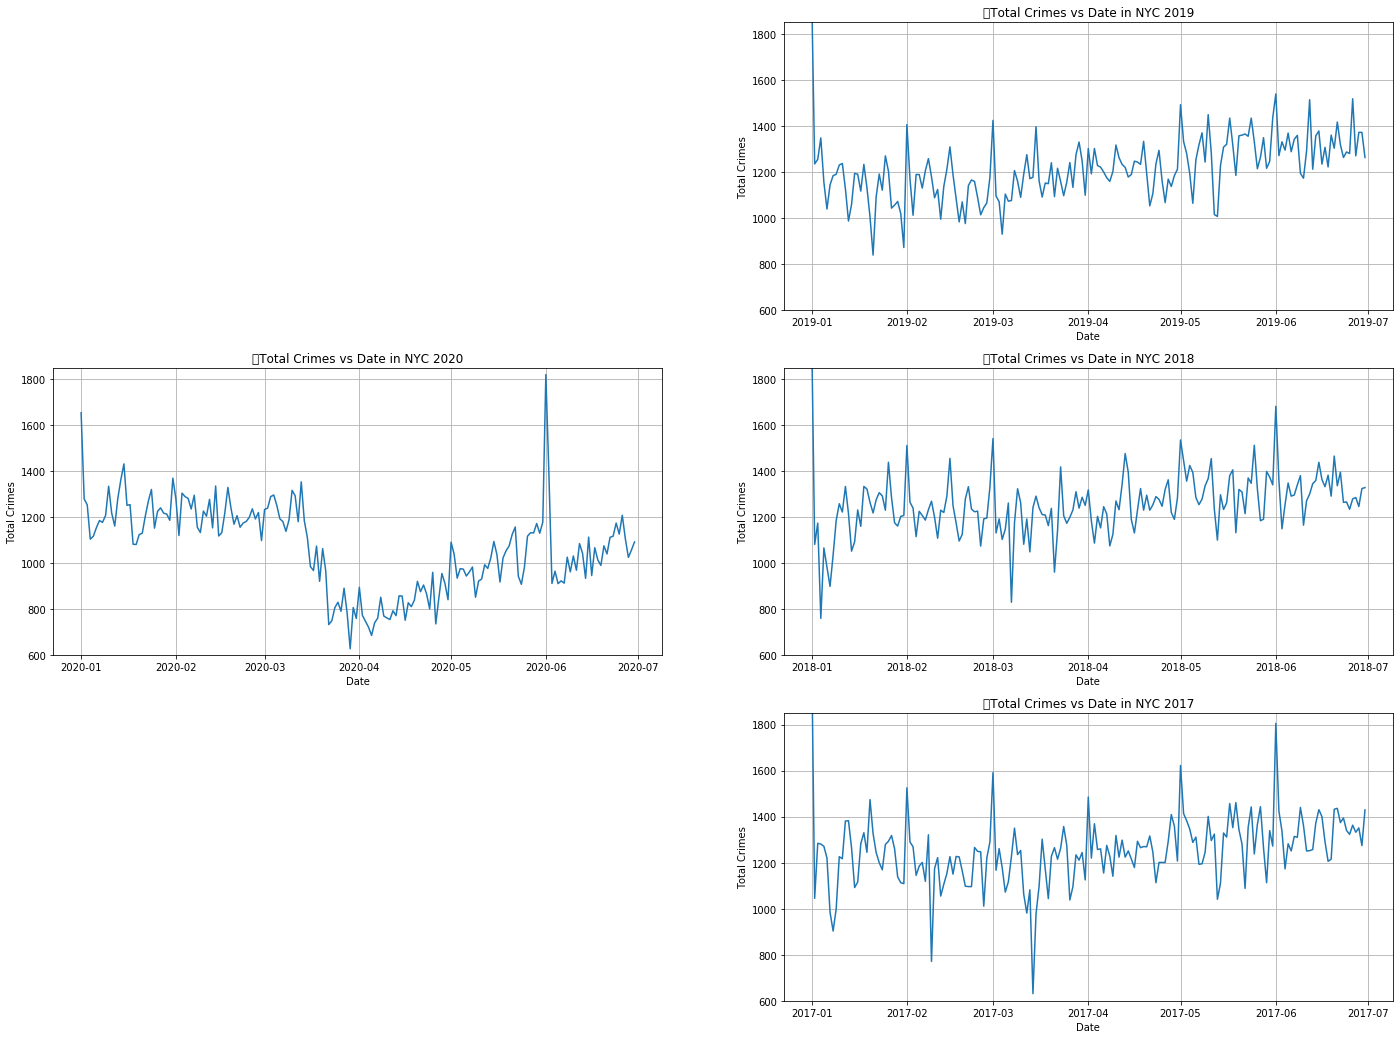

In [548]:
fig = plt.figure(figsize=(24, 18))

ax1 = plt.subplot(3, 2, 3)
ax1.plot(complaint2020Count_date["date"], complaint2020Count_date["total"])
ax1.set(xlabel='Date', ylabel='Total Crimes',
       title='Total Crimes vs Date in NYC 2020')
plt.ylim(600, 1850)
ax1.grid()

ax2 = plt.subplot(3, 2, 2)
ax2.plot(complaint2019Count_date["date"], complaint2019Count_date["total"])
ax2.set(xlabel='Date', ylabel='Total Crimes',
       title='Total Crimes vs Date in NYC 2019')
plt.ylim(600, 1850)
ax2.grid()

ax3 = plt.subplot(3, 2, 4)
ax3.plot(complaint2018Count_date["date"], complaint2018Count_date["total"])
ax3.set(xlabel='Date', ylabel='Total Crimes',
       title='Total Crimes vs Date in NYC 2018')
plt.ylim(600, 1850)
ax3.grid()

ax4 = plt.subplot(3, 2, 6)
ax4.plot(complaint2017Count_date["date"], complaint2017Count_date["total"])
ax4.set(xlabel='Date', ylabel='Total Crimes',
       title='Total Crimes vs Date in NYC 2017')
plt.ylim(600, 1850)
ax4.grid()

plt.show()

In [549]:
# for 2017 data: https://weather.com/storms/winter/news/new-york-snow-winter-storm-stella 03/14/2017

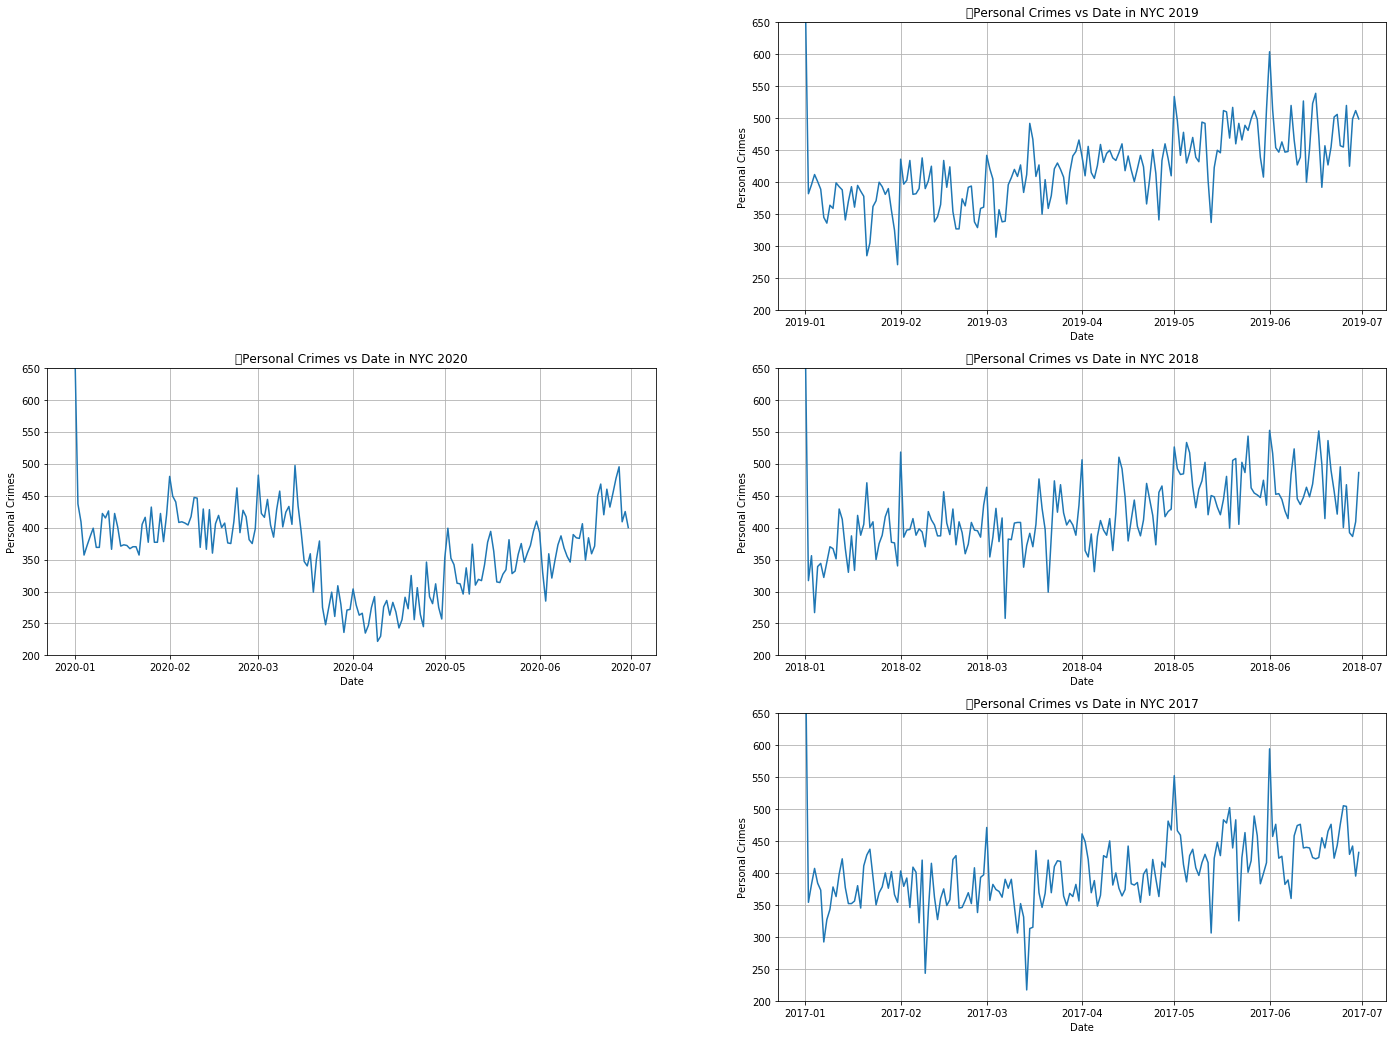

In [550]:
fig = plt.figure(figsize=(24, 18))

ax1 = plt.subplot(3, 2, 3)
ax1.plot(complaint2020Count_date["date"], complaint2020Count_date["personal crimes"])
ax1.set(xlabel='Date', ylabel='Personal Crimes',
       title='Personal Crimes vs Date in NYC 2020')
plt.ylim(200, 650)
ax1.grid()

ax2 = plt.subplot(3, 2, 2)
ax2.plot(complaint2019Count_date["date"], complaint2019Count_date["personal crimes"])
ax2.set(xlabel='Date', ylabel='Personal Crimes',
       title='Personal Crimes vs Date in NYC 2019')
plt.ylim(200, 650)
ax2.grid()

ax3 = plt.subplot(3, 2, 4)
ax3.plot(complaint2018Count_date["date"], complaint2018Count_date["personal crimes"])
ax3.set(xlabel='Date', ylabel='Personal Crimes',
       title='Personal Crimes vs Date in NYC 2018')
plt.ylim(200, 650)
ax3.grid()

ax4 = plt.subplot(3, 2, 6)
ax4.plot(complaint2017Count_date["date"], complaint2017Count_date["personal crimes"])
ax4.set(xlabel='Date', ylabel='Personal Crimes',
       title='Personal Crimes vs Date in NYC 2017')
plt.ylim(200, 650)
ax4.grid()

plt.show()

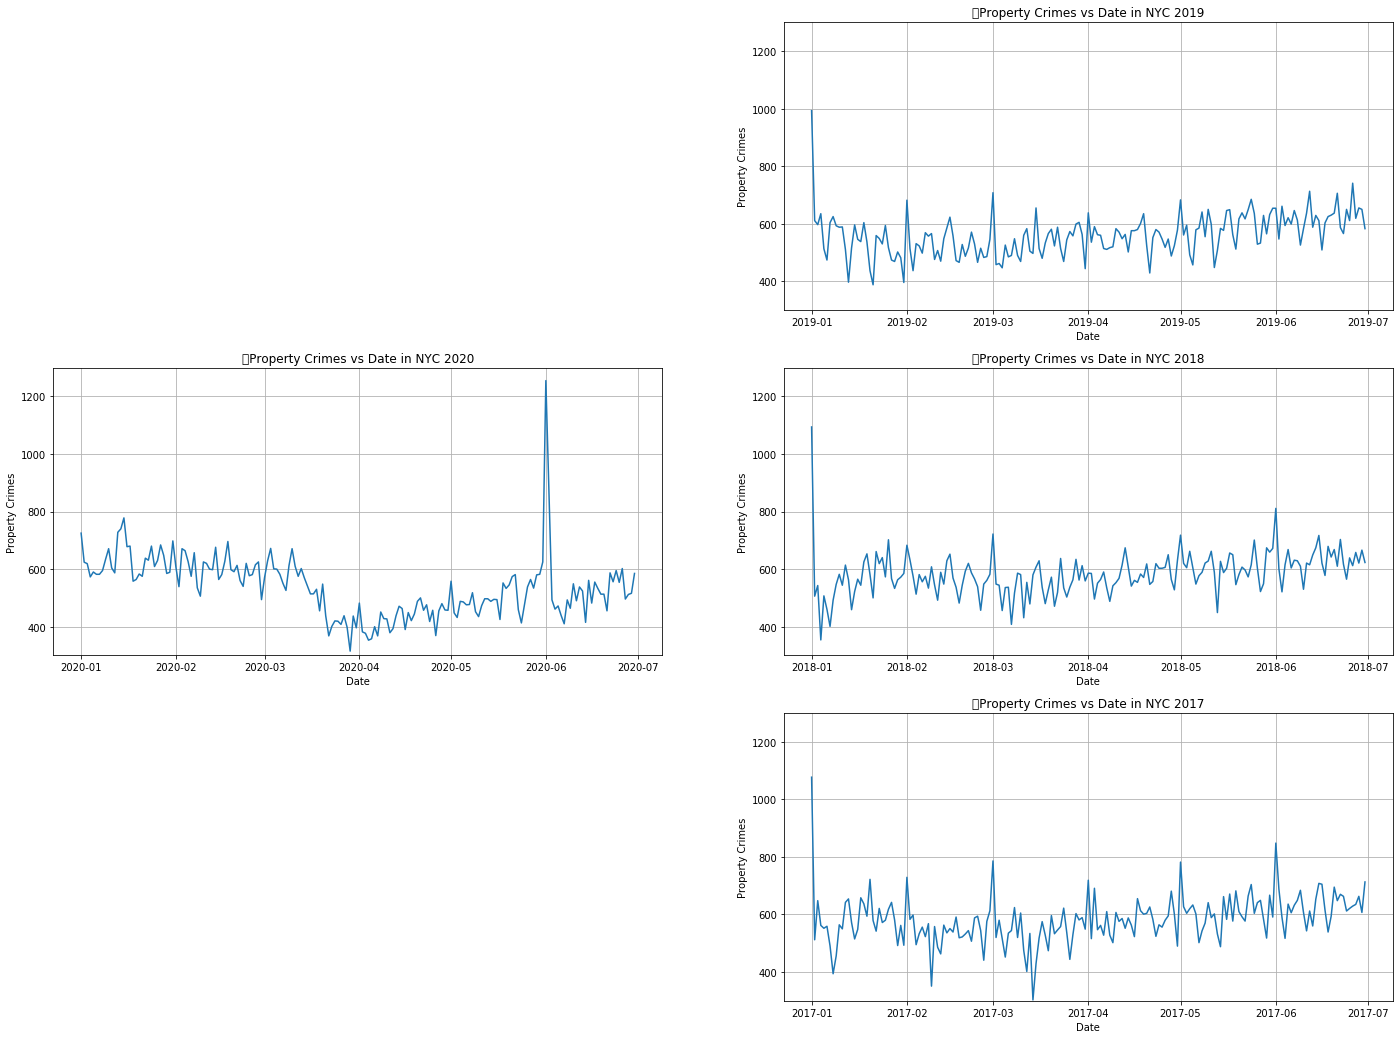

In [551]:
fig = plt.figure(figsize=(24, 18))

ax1 = plt.subplot(3, 2, 3)
ax1.plot(complaint2020Count_date["date"], complaint2020Count_date["property crimes"])
ax1.set(xlabel='Date', ylabel='Property Crimes',
       title='Property Crimes vs Date in NYC 2020')
plt.ylim(300, 1300)
ax1.grid()

ax2 = plt.subplot(3, 2, 2)
ax2.plot(complaint2019Count_date["date"], complaint2019Count_date["property crimes"])
ax2.set(xlabel='Date', ylabel='Property Crimes',
       title='Property Crimes vs Date in NYC 2019')
plt.ylim(300, 1300)
ax2.grid()

ax3 = plt.subplot(3, 2, 4)
ax3.plot(complaint2018Count_date["date"], complaint2018Count_date["property crimes"])
ax3.set(xlabel='Date', ylabel='Property Crimes',
       title='Property Crimes vs Date in NYC 2018')
plt.ylim(300, 1300)
ax3.grid()

ax4 = plt.subplot(3, 2, 6)
ax4.plot(complaint2017Count_date["date"], complaint2017Count_date["property crimes"])
ax4.set(xlabel='Date', ylabel='Property Crimes',
       title='Property Crimes vs Date in NYC 2017')
plt.ylim(300, 1300)
ax4.grid()

plt.show()

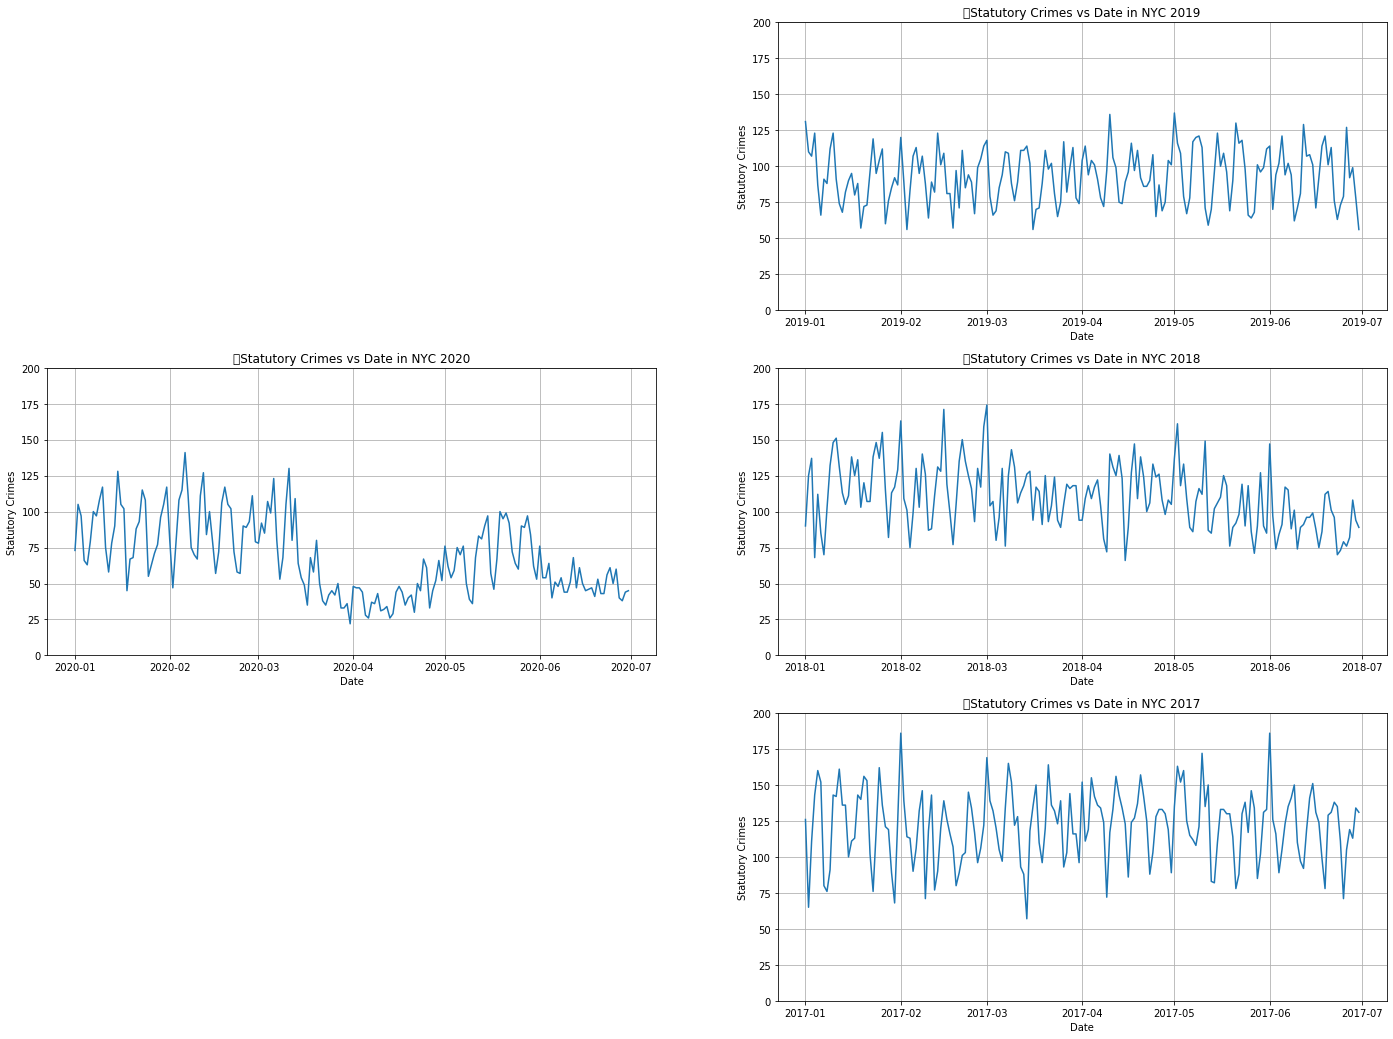

In [552]:
fig = plt.figure(figsize=(24, 18))

ax1 = plt.subplot(3, 2, 3)
ax1.plot(complaint2020Count_date["date"], complaint2020Count_date["statutory crimes"])
ax1.set(xlabel='Date', ylabel='Statutory Crimes',
       title='Statutory Crimes vs Date in NYC 2020')
plt.ylim(0, 200)
ax1.grid()

ax2 = plt.subplot(3, 2, 2)
ax2.plot(complaint2019Count_date["date"], complaint2019Count_date["statutory crimes"])
ax2.set(xlabel='Date', ylabel='Statutory Crimes',
       title='Statutory Crimes vs Date in NYC 2019')
plt.ylim(0, 200)
ax2.grid()

ax3 = plt.subplot(3, 2, 4)
ax3.plot(complaint2018Count_date["date"], complaint2018Count_date["statutory crimes"])
ax3.set(xlabel='Date', ylabel='Statutory Crimes',
       title='Statutory Crimes vs Date in NYC 2018')
plt.ylim(0, 200)
ax3.grid()

ax4 = plt.subplot(3, 2, 6)
ax4.plot(complaint2017Count_date["date"], complaint2017Count_date["statutory crimes"])
ax4.set(xlabel='Date', ylabel='Statutory Crimes',
       title='Statutory Crimes vs Date in NYC 2017')
plt.ylim(0, 200)
ax4.grid()

plt.show()

In [553]:
# on march 15th, school closed. on march 22th, shelter in order start to take effects https://abcnews.go.com/US/News/timeline-100-days-york-gov-andrew-cuomos-covid/story?id=71292880

In [554]:
#divided data 15, 22

In [555]:
time_delta = complaint2020Count_date["date"] - pd.to_datetime('01/31/2020', format='%m/%d/%Y')
complaint2020Count_date["time_delta"] = np.array(time_delta.index)

In [556]:
complaint2020Count_date["xt"] = [ 0 if date<pd.to_datetime('03/15/2020', format='%m/%d/%Y') else 1 for date in complaint2020Count_date["date"]]
complaint2020Count_date["xt2"] = [ 0 if date<pd.to_datetime('03/22/2020', format='%m/%d/%Y') else 1 for date in complaint2020Count_date["date"]]

In [557]:
from scipy import stats
from sklearn.metrics import r2_score

In [558]:
def itsa(crimedata, name):
    phase1 = crimedata[crimedata["date"]<pd.to_datetime('03/15/2020', format='%m/%d/%Y')]
    phase2 = crimedata[(crimedata["date"]>pd.to_datetime('03/14/2020', format='%m/%d/%Y')) & (crimedata["date"]<pd.to_datetime('03/22/2020', format='%m/%d/%Y'))]
    phase3 = crimedata[crimedata["date"]>pd.to_datetime('03/21/2020', format='%m/%d/%Y')]

    lm1 = sm.OLS(phase1[name], sm.add_constant(phase1["time_delta"])).fit()
    lm2 = sm.OLS(phase2[name], sm.add_constant(phase2["time_delta"])).fit()
    lm3 = sm.OLS(phase3[name], sm.add_constant(phase3["time_delta"])).fit()

    coef = [
        lm1.params.const,
        lm1.params.time_delta,
        lm2.params.const - lm1.params.const,
        lm2.params.time_delta - lm1.params.time_delta,
        lm3.params.const - lm2.params.const,
        lm3.params.time_delta - lm2.params.time_delta
        ]

    return coef

In [559]:
def itsa_model(v, coef):
    y = coef[0] + coef[1]*v.time_delta + coef[2]*v.xt + coef[3]*v.xt*v.time_delta + coef[4]*v.xt2 + coef[5]*v.xt2*v.time_delta
    return y

In [579]:
def itsa_plot(crimedata, name):
    coef = itsa(crimedata, name)
    print(f"itsa model of {name}: y = {round(coef[0], 4)} + {round(coef[1], 4)}*t1 + {round(coef[2], 4)}*x1 + {round(coef[3], 4)}*x1*t1 + {round(coef[4], 4)}*x2 + {round(coef[5], 4)}*x2*t1")
    itsa_predict = [itsa_model(row, coef) for index, row in crimedata.iterrows()]

    pvalue = stats.ttest_ind(complaint2020Count_date[name], itsa_predict, equal_var = False)
    r2 = r2_score(complaint2020Count_date[name], itsa_predict)

    print(name, f"p-value: {round(1-pvalue.pvalue, 4)}", f"r2: {round(r2, 4)}")


    plt.figure(figsize=(10, 6))

    plt.plot(complaint2020Count_date["date"],complaint2020Count_date[name],'y', label="crime data") #plot the data
    plt.plot(complaint2020Count_date["date"][:74],itsa_predict[:74],'b', label="prediction") #plot the regression
    plt.plot(complaint2020Count_date["date"][74:81],itsa_predict[74:81],'b')
    plt.plot(complaint2020Count_date["date"][81:],itsa_predict[81:],'b')
    plt.axvline(complaint2020Count_date["date"][74],color='r',linestyle='--', label="break point")
    plt.axvline(complaint2020Count_date["date"][80],color='r',linestyle='--')


    plt.legend(loc='lower right')
    plt.xlabel('date')
    plt.ylabel(f'{name}')
    plt.title(f'{name} vs date')

    plt.text(-0.05, -0.05, f"p-value: {round(1-pvalue.pvalue, 4)}\nr2: {round(r2, 4)}\n", size=11,
         va="baseline", ha="left", multialignment="left", transform=ax.transAxes)

    plt.savefig(f'figs/itsa_{name}')

In [561]:
complaint2020Count_date.columns

Index(['date', 'other crimes', 'personal crimes', 'property crimes',
       'statutory crimes', 'traffic crimes', 'total', 'time_delta', 'xt',
       'xt2'],
      dtype='object')

itsa model of total: y = 1240.4238 + -0.3681*t1 + 661.5405*x1 + -11.1676*x1*t1 + -1466.8265*x2 + 15.4999*x2*t1
total p-value: 0.0 r2: 0.6954
itsa model of personal crimes: y = 401.2584 + 0.2421*t1 + 171.3131*x1 + -3.0992*x1*t1 + -474.8755*x2 + 4.6401*x2*t1
personal crimes p-value: 0.0 r2: 0.6786
itsa model of property crimes: y = 641.5643 + -0.7626*t1 + 697.5428*x1 + -10.0588*x1*t1 + -1093.8541*x2 + 12.6587*x2*t1
property crimes p-value: 0.0 r2: 0.4839
itsa model of statutory crimes: y = 86.8886 + 0.0564*t1 + -231.3529*x1 + 2.5508*x1*t1 + 170.9797*x2 + -2.4015*x2*t1
statutory crimes p-value: 0.0 r2: 0.4673
itsa model of traffic crimes: y = 13.787 + 0.028*t1 + 179.2487*x1 + -2.3495*x1*t1 + -189.5949*x2 + 2.3583*x2*t1
traffic crimes p-value: 0.0 r2: 0.2955
itsa model of other crimes: y = 96.9254 + 0.0679*t1 + -155.2111*x1 + 1.7892*x1*t1 + 120.5182*x2 + -1.7557*x2*t1
other crimes p-value: 0.0 r2: 0.3299


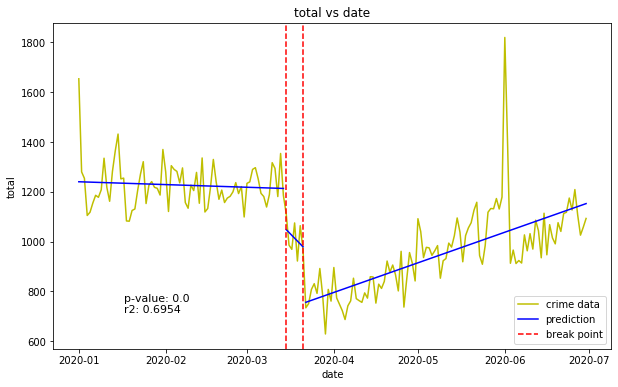

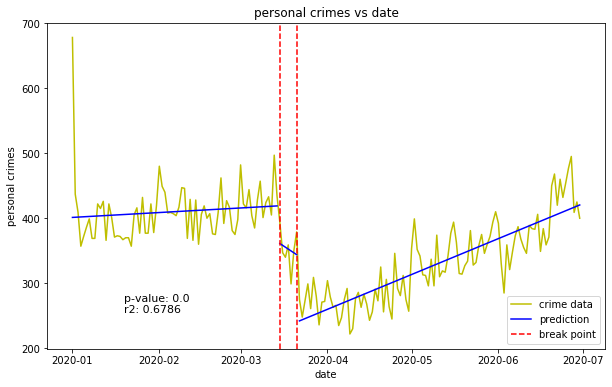

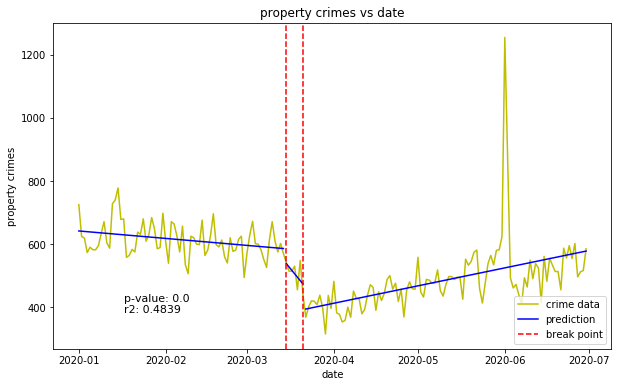

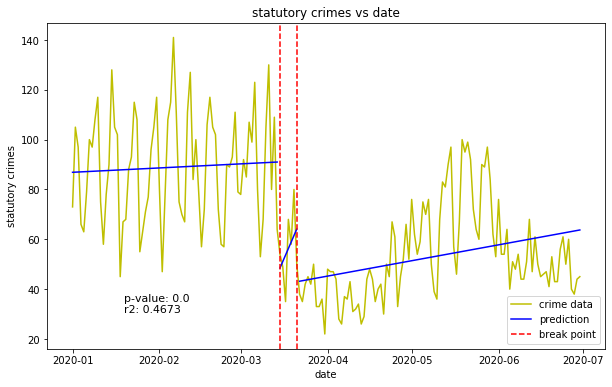

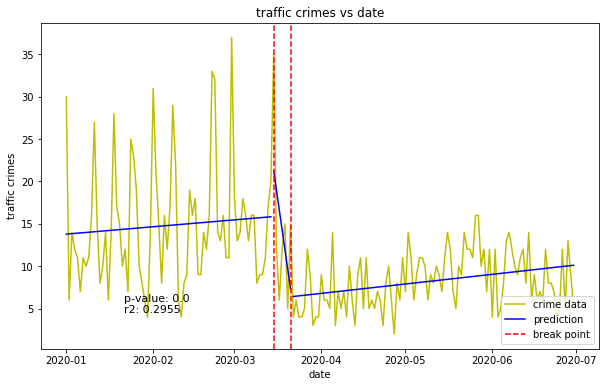

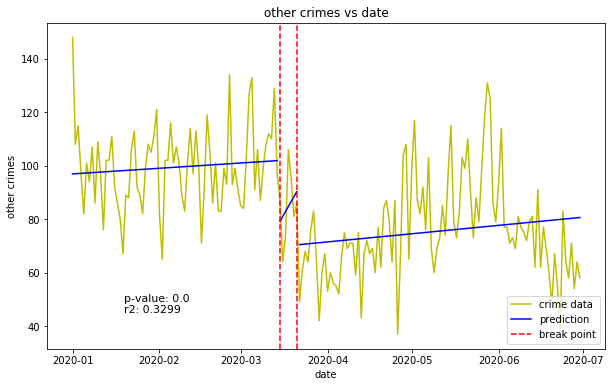

In [580]:
itsa_plot(complaint2020Count_date, "total")
itsa_plot(complaint2020Count_date, "personal crimes")
itsa_plot(complaint2020Count_date, "property crimes")
itsa_plot(complaint2020Count_date, "statutory crimes")
itsa_plot(complaint2020Count_date, "traffic crimes")
itsa_plot(complaint2020Count_date, "other crimes")

In [563]:
import statsmodels.tsa.ar_model as ar

In [564]:
model_fit = ar.AutoReg(complaint2020Count_date["total"], lags=1, trend='ct').fit()

In [565]:
model_fit.params

intercept    278.077477
trend         -0.262286
total.L1       0.759184
dtype: float64

No handles with labels found to put in legend.


Text(0, 0.5, 'total crimes')

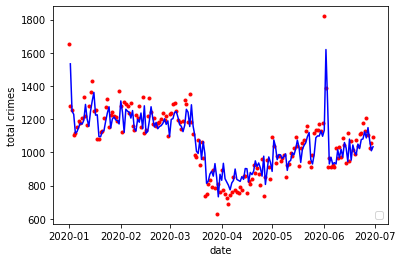

In [566]:
plt.plot(complaint2020Count_date["date"],complaint2020Count_date["total"],'.r') #plot the data
plt.plot(complaint2020Count_date["date"],model_fit.predict(),'b') #plot the regression
plt.legend(loc='lower right')
plt.xlabel('date')
plt.ylabel('total crimes')

In [567]:
mod = ar.ar_select_order(complaint2020Count_date["total"], maxlag=15)
print(mod.ar_lags)

[1 2 3]


In [568]:
mod = ar.ar_select_order(complaint2017Count_date["total"], maxlag=15)
print(mod.ar_lags)

[1]


In [569]:
from statsmodels.tsa.arima.model import ARIMA

In [663]:
def sarima_crime(crimedata, name, year):
    train = crimedata[crimedata["date"]<pd.to_datetime(f'03/15/{year}', format='%m/%d/%Y')]
    arima = ARIMA(train[name], order=(1,1,5), dates=train["date"]).fit()

    predict = arima.get_forecast(48)
    predict_ci = predict.conf_int(alpha=0.05)
    predict_l = predict.predicted_mean

    predictwilder = arima.get_forecast(48).conf_int(alpha=0.2)

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(crimedata["date"][:121],crimedata[name][:121],'y', label="actual crime")
    ax.plot(crimedata["date"][73:121],predict_l,'b', label="predicted crime")
    ax.axvline(crimedata["date"][73],color='r',linestyle='--')

    ax.fill_between(crimedata["date"][73:121],
                    predict_ci.iloc[:, 0],
                    predict_ci.iloc[:, 1], color='k', alpha=.1, label="ci = 95%")
    ax.fill_between(crimedata["date"][73:121],
                    predictwilder.iloc[:, 0],
                    predictwilder.iloc[:, 1], color='blue', alpha=.1, label="ci = 80%")               

    plt.legend(loc='lower right')
    plt.xlabel('date')
    plt.ylabel(name)
    plt.title(f'ARIMA {name} vs data {year}')


    plt.savefig(f'figs/sarima_{name}_{year}')

In [664]:
complaint2020Count_date["personal crimes percentage"] = complaint2020Count_date["personal crimes"]/complaint2020Count_date["total"]
complaint2020Count_date["property crimes percentage"] = complaint2020Count_date["property crimes"]/complaint2020Count_date["total"]
complaint2020Count_date["statutory crimes percentage"] = complaint2020Count_date["statutory crimes"]/complaint2020Count_date["total"]
complaint2020Count_date["traffic crimes percentage"] = complaint2020Count_date["traffic crimes"]/complaint2020Count_date["total"]
complaint2020Count_date["other crimes percentage"] = complaint2020Count_date["other crimes"]/complaint2020Count_date["total"]

/Users/eveshi/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/eveshi/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/eveshi/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/eveshi/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/eveshi/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so

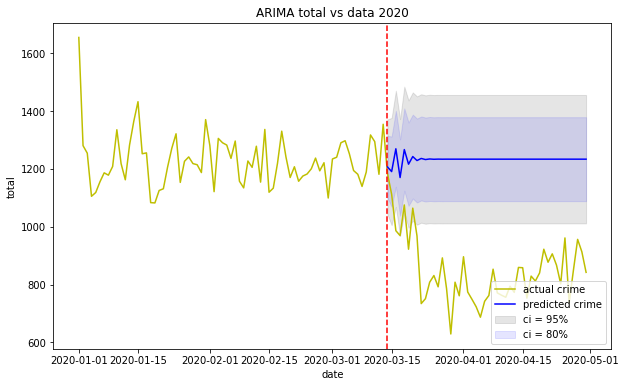

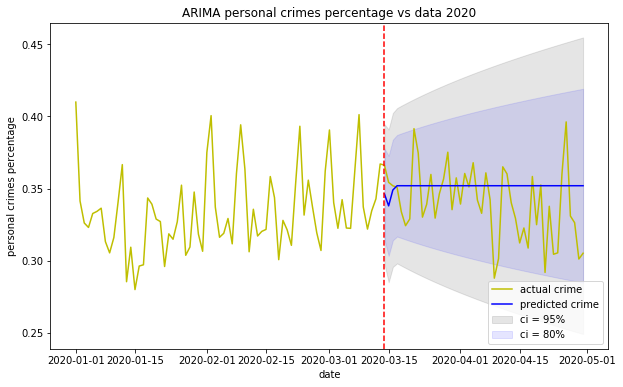

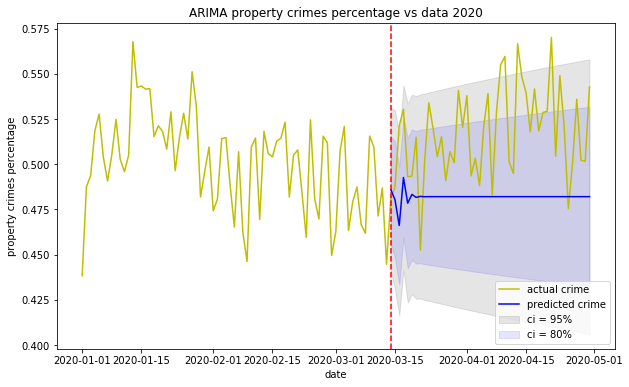

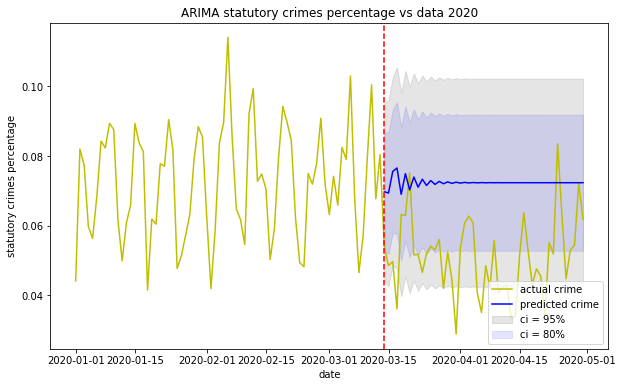

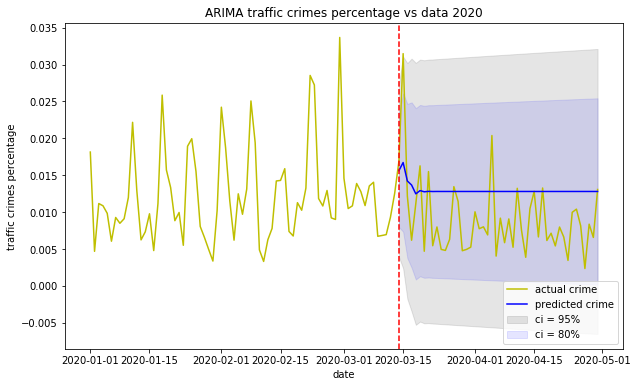

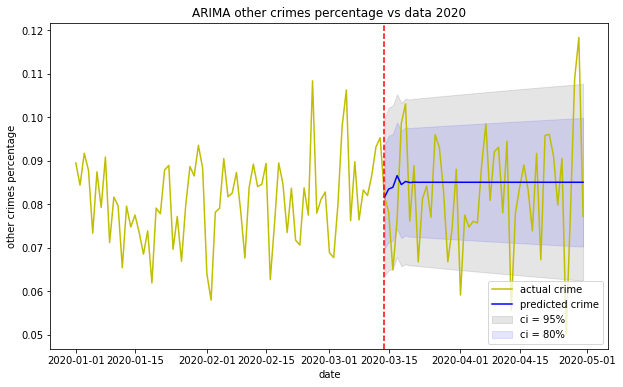

In [665]:
sarima_crime(complaint2020Count_date, "total", 2020)

sarima_crime(complaint2020Count_date, "personal crimes percentage", 2020)
sarima_crime(complaint2020Count_date, "property crimes percentage", 2020)
sarima_crime(complaint2020Count_date, "statutory crimes percentage", 2020)
sarima_crime(complaint2020Count_date, "traffic crimes percentage", 2020)
sarima_crime(complaint2020Count_date, "other crimes percentage", 2020)


In [666]:
complaint2019Count_date["personal crimes percentage"] = complaint2019Count_date["personal crimes"]/complaint2019Count_date["total"]
complaint2019Count_date["property crimes percentage"] = complaint2019Count_date["property crimes"]/complaint2019Count_date["total"]
complaint2019Count_date["statutory crimes percentage"] = complaint2019Count_date["statutory crimes"]/complaint2019Count_date["total"]
complaint2019Count_date["traffic crimes percentage"] = complaint2019Count_date["traffic crimes"]/complaint2019Count_date["total"]
complaint2019Count_date["other crimes percentage"] = complaint2019Count_date["other crimes"]/complaint2019Count_date["total"]

In [667]:
complaint2018Count_date["personal crimes percentage"] = complaint2018Count_date["personal crimes"]/complaint2018Count_date["total"]
complaint2018Count_date["property crimes percentage"] = complaint2018Count_date["property crimes"]/complaint2018Count_date["total"]
complaint2018Count_date["statutory crimes percentage"] = complaint2018Count_date["statutory crimes"]/complaint2018Count_date["total"]
complaint2018Count_date["traffic crimes percentage"] = complaint2018Count_date["traffic crimes"]/complaint2018Count_date["total"]
complaint2018Count_date["other crimes percentage"] = complaint2018Count_date["other crimes"]/complaint2018Count_date["total"]

In [668]:
complaint2017Count_date["personal crimes percentage"] = complaint2017Count_date["personal crimes"]/complaint2017Count_date["total"]
complaint2017Count_date["property crimes percentage"] = complaint2017Count_date["property crimes"]/complaint2017Count_date["total"]
complaint2017Count_date["statutory crimes percentage"] = complaint2017Count_date["statutory crimes"]/complaint2017Count_date["total"]
complaint2017Count_date["traffic crimes percentage"] = complaint2017Count_date["traffic crimes"]/complaint2017Count_date["total"]
complaint2017Count_date["other crimes percentage"] = complaint2017Count_date["other crimes"]/complaint2017Count_date["total"]

/Users/eveshi/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/eveshi/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/eveshi/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/eveshi/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/eveshi/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. C

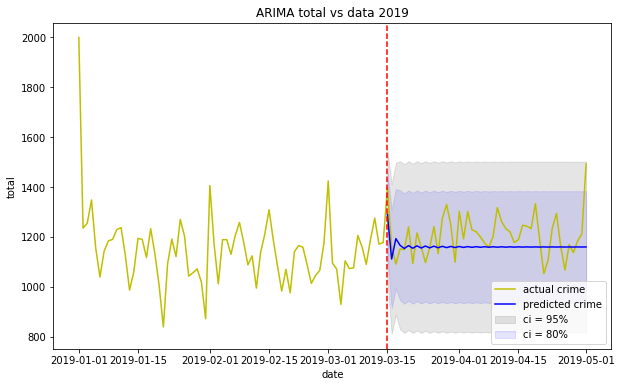

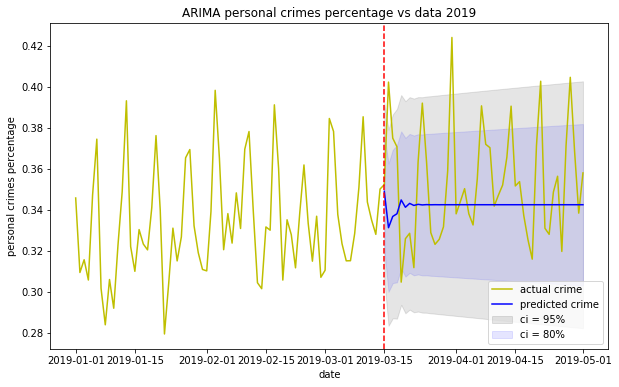

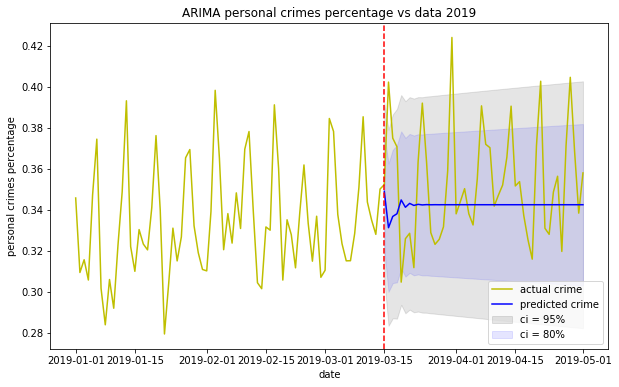

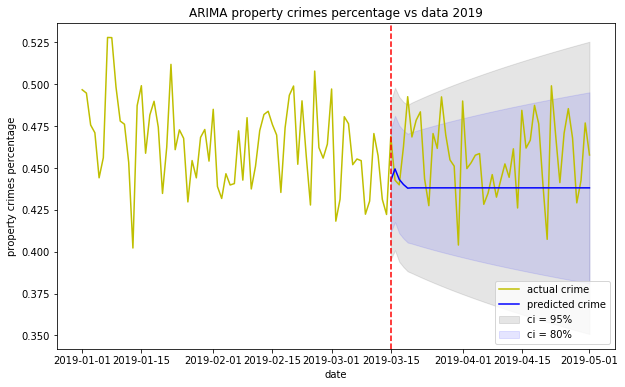

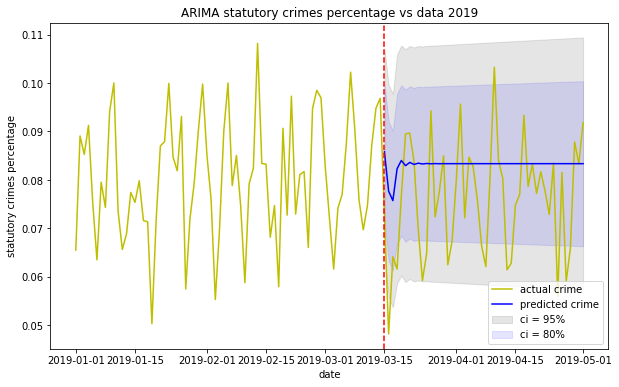

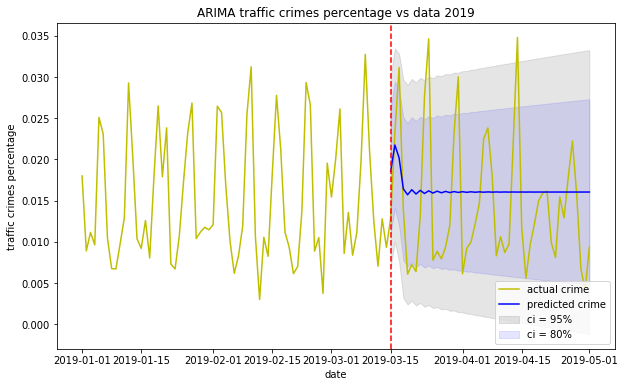

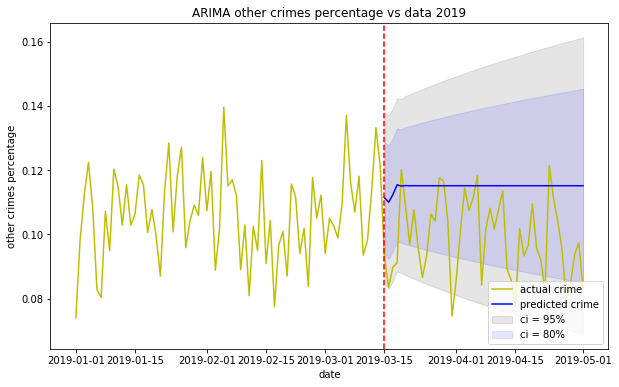

In [669]:
sarima_crime(complaint2019Count_date, "total", 2019)

sarima_crime(complaint2019Count_date, "personal crimes percentage", 2019)
sarima_crime(complaint2019Count_date, "personal crimes percentage", 2019)
sarima_crime(complaint2019Count_date, "property crimes percentage", 2019)
sarima_crime(complaint2019Count_date, "statutory crimes percentage", 2019)
sarima_crime(complaint2019Count_date, "traffic crimes percentage", 2019)
sarima_crime(complaint2019Count_date, "other crimes percentage", 2019)

/Users/eveshi/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/eveshi/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/eveshi/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/eveshi/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/eveshi/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. C

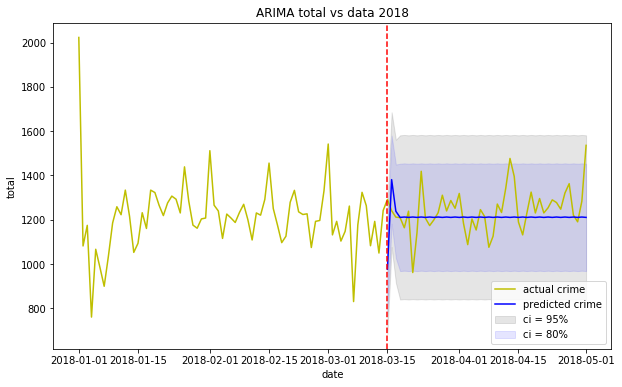

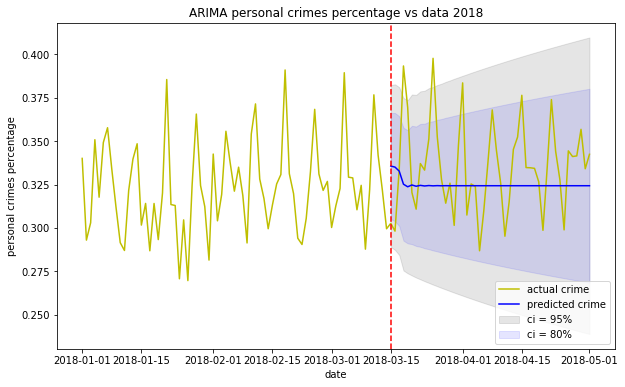

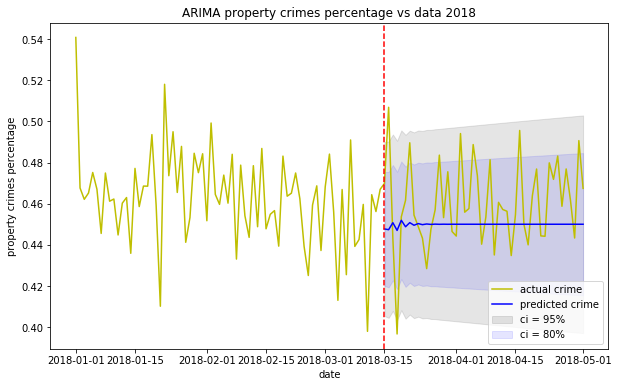

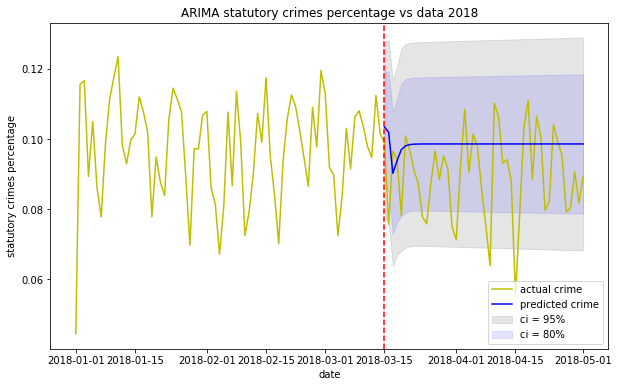

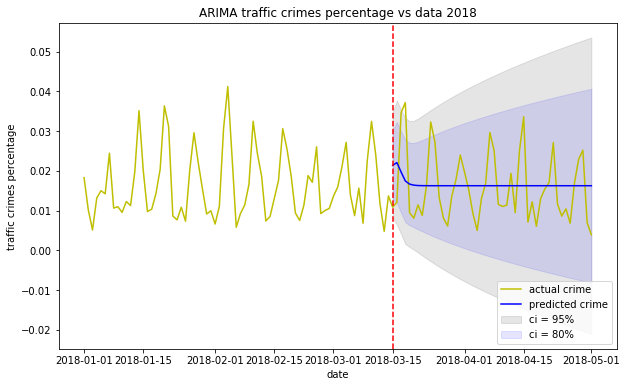

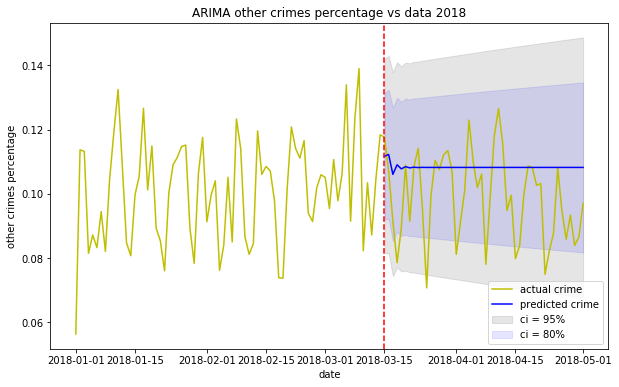

In [670]:
sarima_crime(complaint2018Count_date, "total", 2018)

sarima_crime(complaint2018Count_date, "personal crimes percentage", 2018)
sarima_crime(complaint2018Count_date, "property crimes percentage", 2018)
sarima_crime(complaint2018Count_date, "statutory crimes percentage", 2018)
sarima_crime(complaint2018Count_date, "traffic crimes percentage", 2018)
sarima_crime(complaint2018Count_date, "other crimes percentage", 2018)

/Users/eveshi/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/eveshi/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/eveshi/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/eveshi/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/eveshi/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. C

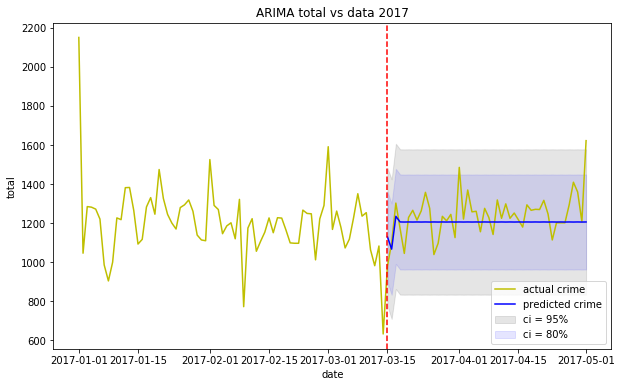

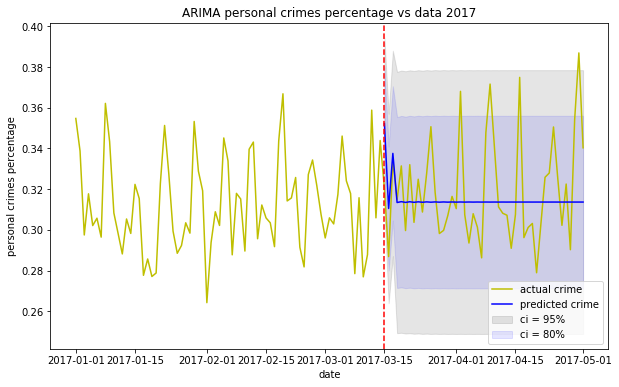

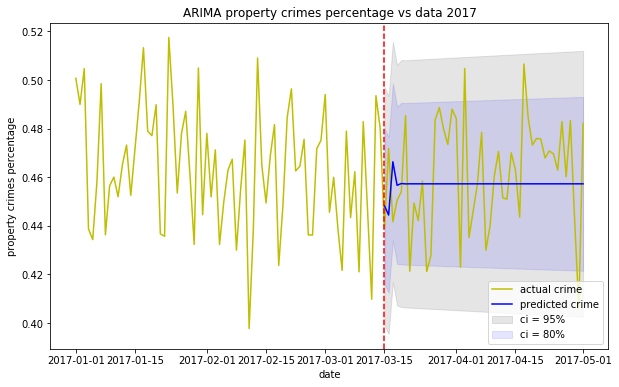

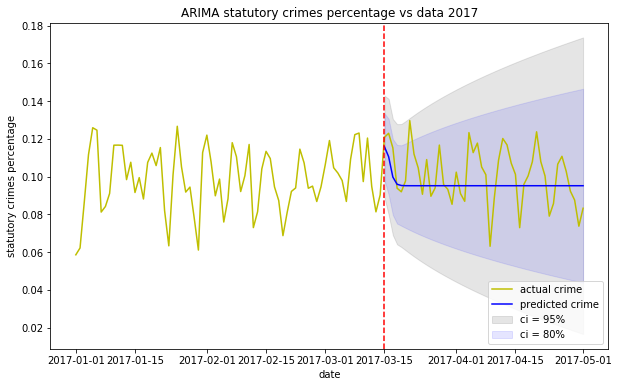

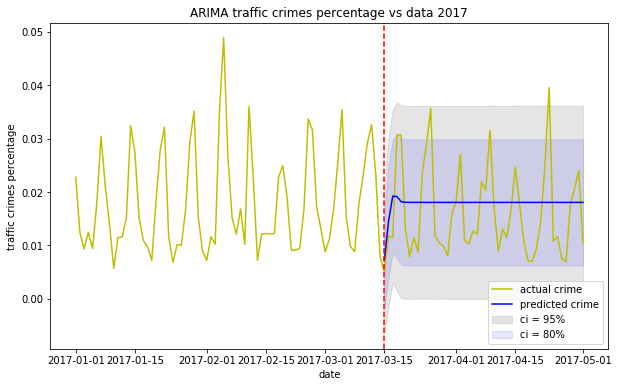

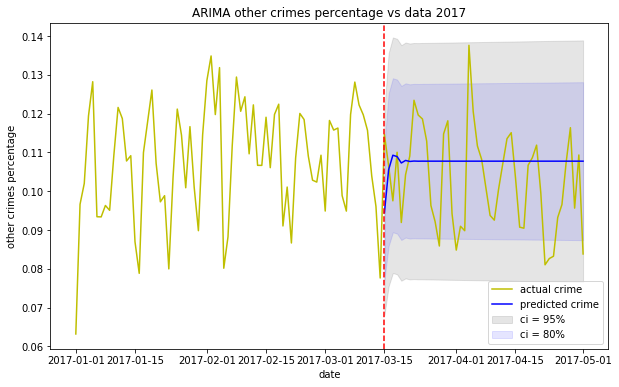

In [671]:
sarima_crime(complaint2017Count_date, "total", 2017)

sarima_crime(complaint2017Count_date, "personal crimes percentage", 2017)
sarima_crime(complaint2017Count_date, "property crimes percentage", 2017)
sarima_crime(complaint2017Count_date, "statutory crimes percentage", 2017)
sarima_crime(complaint2017Count_date, "traffic crimes percentage", 2017)
sarima_crime(complaint2017Count_date, "other crimes percentage", 2017)

itsa model of personal crimes percentage: y = 0.3228 + 0.0003*t1 + -0.0823*x1 + 0.0011*x1*t1 + 0.0513*x2 + -0.001*x2*t1
personal crimes percentage p-value: 0.0 r2: 0.1314
itsa model of property crimes percentage: y = 0.5183 + -0.0005*t1 + 0.405*x1 + -0.005*x1*t1 + -0.3822*x2 + 0.0053*x2*t1
property crimes percentage p-value: 0.0 r2: 0.0922
itsa model of statutory crimes percentage: y = 0.07 + 0.0001*t1 + -0.254*x1 + 0.003*x1*t1 + 0.238*x2 + -0.0031*x2*t1
statutory crimes percentage p-value: 0.0 r2: 0.2287
itsa model of traffic crimes percentage: y = 0.0111 + 0.0*t1 + 0.1481*x1 + -0.0019*x1*t1 + -0.1514*x2 + 0.0019*x2*t1
traffic crimes percentage p-value: 0.0 r2: 0.1495
itsa model of other crimes percentage: y = 0.0779 + 0.0001*t1 + -0.2167*x1 + 0.0028*x1*t1 + 0.2444*x2 + -0.0031*x2*t1
other crimes percentage p-value: 0.0 r2: 0.1214


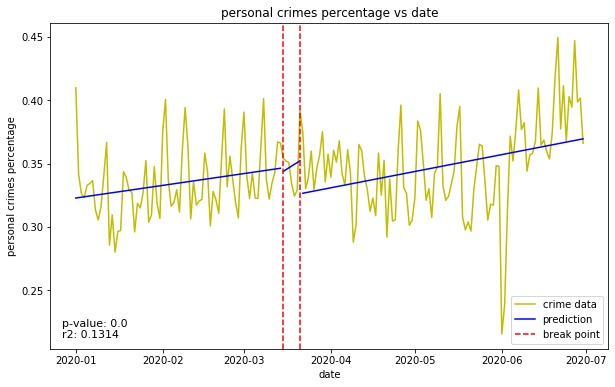

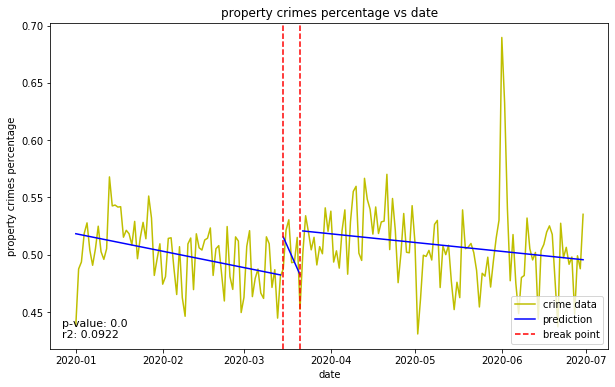

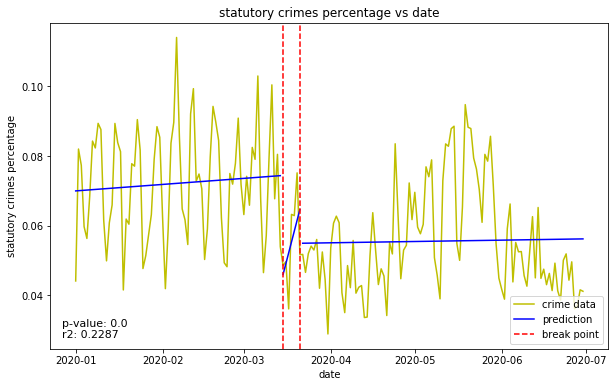

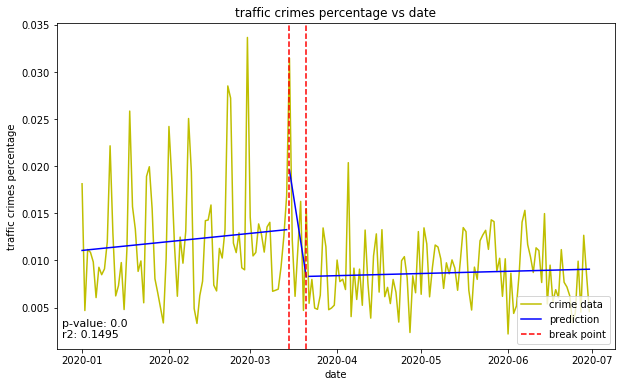

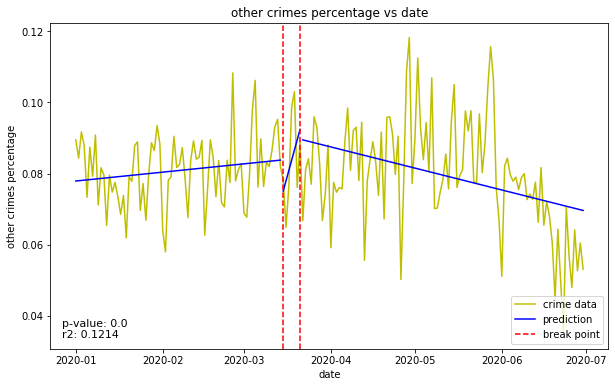

In [672]:
itsa_plot(complaint2020Count_date, "personal crimes percentage")
itsa_plot(complaint2020Count_date, "property crimes percentage")
itsa_plot(complaint2020Count_date, "statutory crimes percentage")
itsa_plot(complaint2020Count_date, "traffic crimes percentage")
itsa_plot(complaint2020Count_date, "other crimes percentage")